In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
import pickle
from src.AmortizedMixture import *
from src.models.NormalMixture import *

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
model = NormalMixture(n_cls=2, n_obs=[50, 250], n_rep=[1,10])

In [3]:
local_summary_net = bf.networks.DeepSet(summary_dim=2)
global_summary_net = bf.networks.DeepSet(summary_dim=model.n_cls*2*2)
trainer = bf.trainers.Trainer(
    amortizer=AmortizedMixturePosterior(
        amortized_mixture=AmortizedMixture(
            inference_net=IndependentClassificator(num_outputs=model.n_cls),
            local_summary_net=local_summary_net
        ),
        amortized_posterior=bf.amortizers.AmortizedPosterior(
            inference_net=bf.networks.InvertibleNetwork(num_params=model.n_cls*2), 
            summary_net=bf.networks.HierarchicalNetwork([local_summary_net, global_summary_net])
        )
    ), 
    generative_model=model, 
    configurator=lambda x: x, 
    checkpoint_path="checkpoints/mixture_posterior")

INFO:root:Loaded loss history from checkpoints/mixture_posterior/history_20.pkl.
INFO:root:Networks loaded from checkpoints/mixture_posterior/ckpt-20
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [5]:
%%time
h = trainer.train_online(epochs=20, iterations_per_epoch=1000, batch_size=64)

Training epoch 20: 100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s, Epoch: 20, Iter: 1000,Mix.Loss: 8.944,Post.Loss: -4.890,W.Decay: 0.106,Avg.Mix.Loss: 19.455,Avg.Post.Loss: -4.563,Avg.W.Decay: 0.106,LR: 0.00E+00]


CPU times: user 4h 7min 20s, sys: 1h 9min 28s, total: 5h 16min 48s
Wall time: 1h 18min 25s


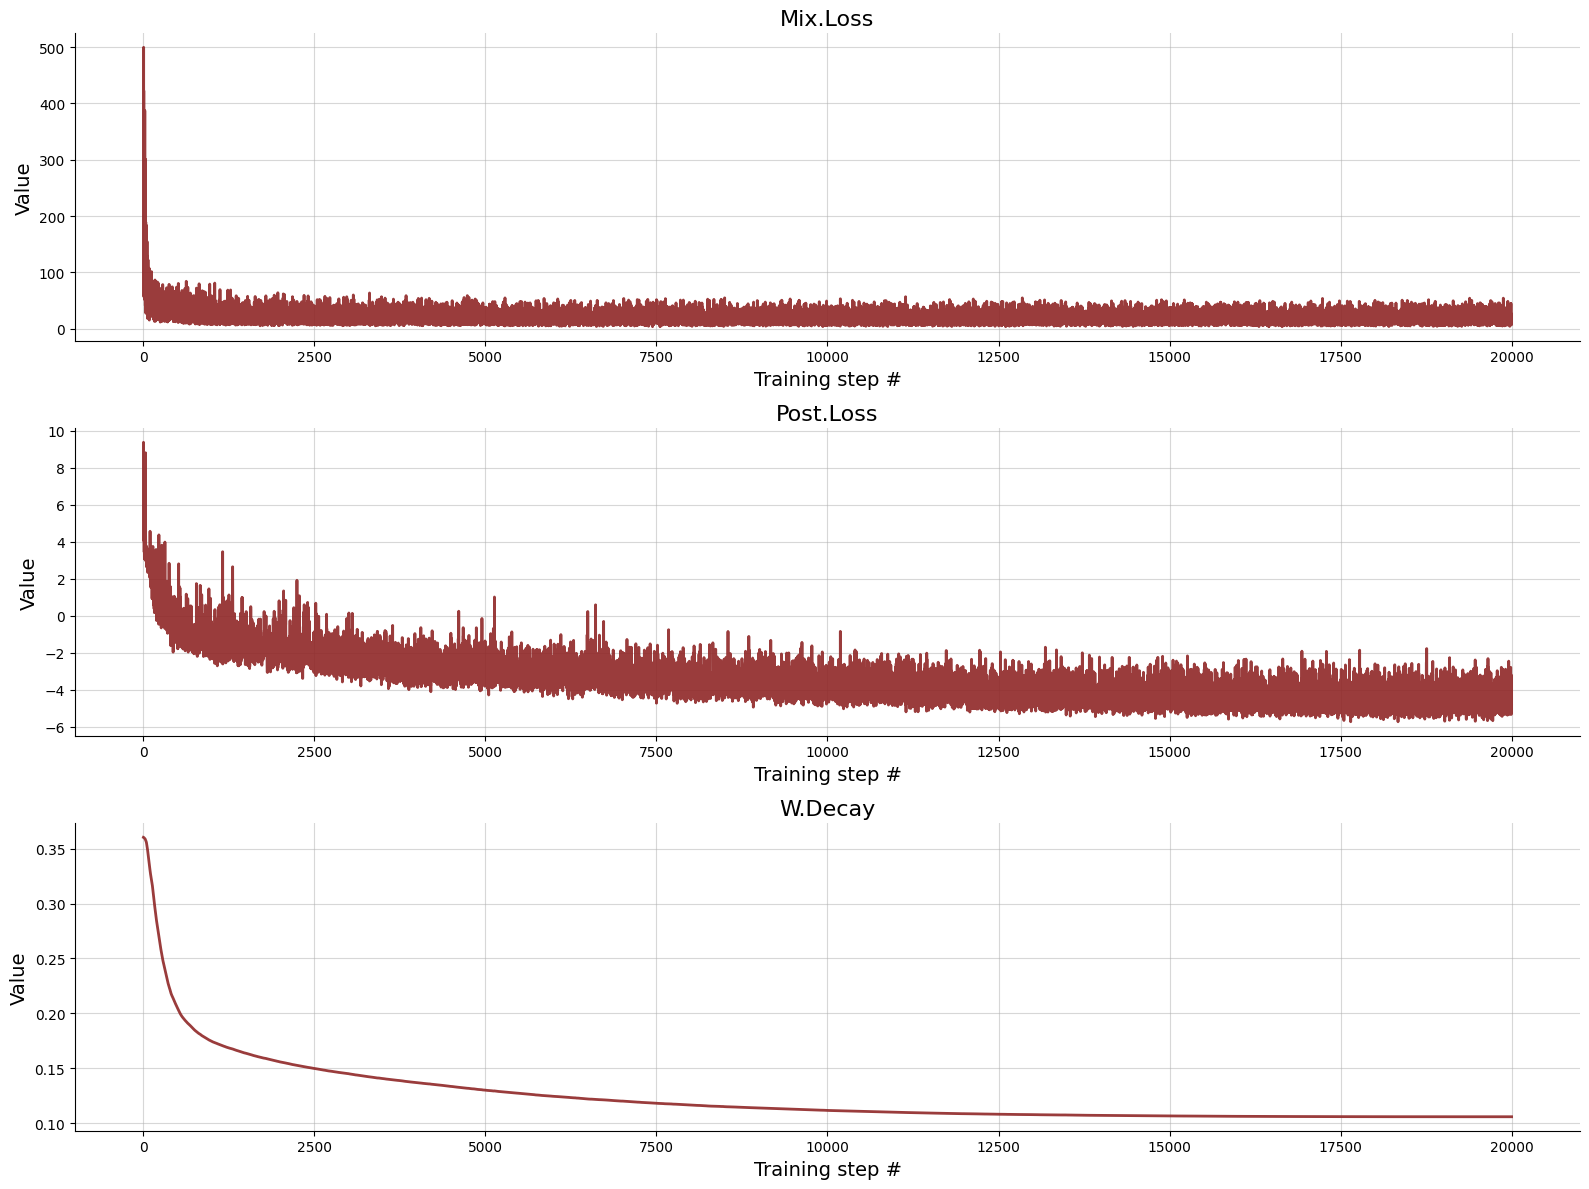

In [6]:
f=bf.diagnostics.plot_losses(h)

## Diagnostics

In [4]:
context = {'n_obs': 200, 'n_rep': 1}
df = model(500, context=context)

In [9]:
out = trainer.amortizer.sample(df, n_samples=500)

In [20]:
prior_samples = np.array(df['parameters'])
post_samples = out[0]

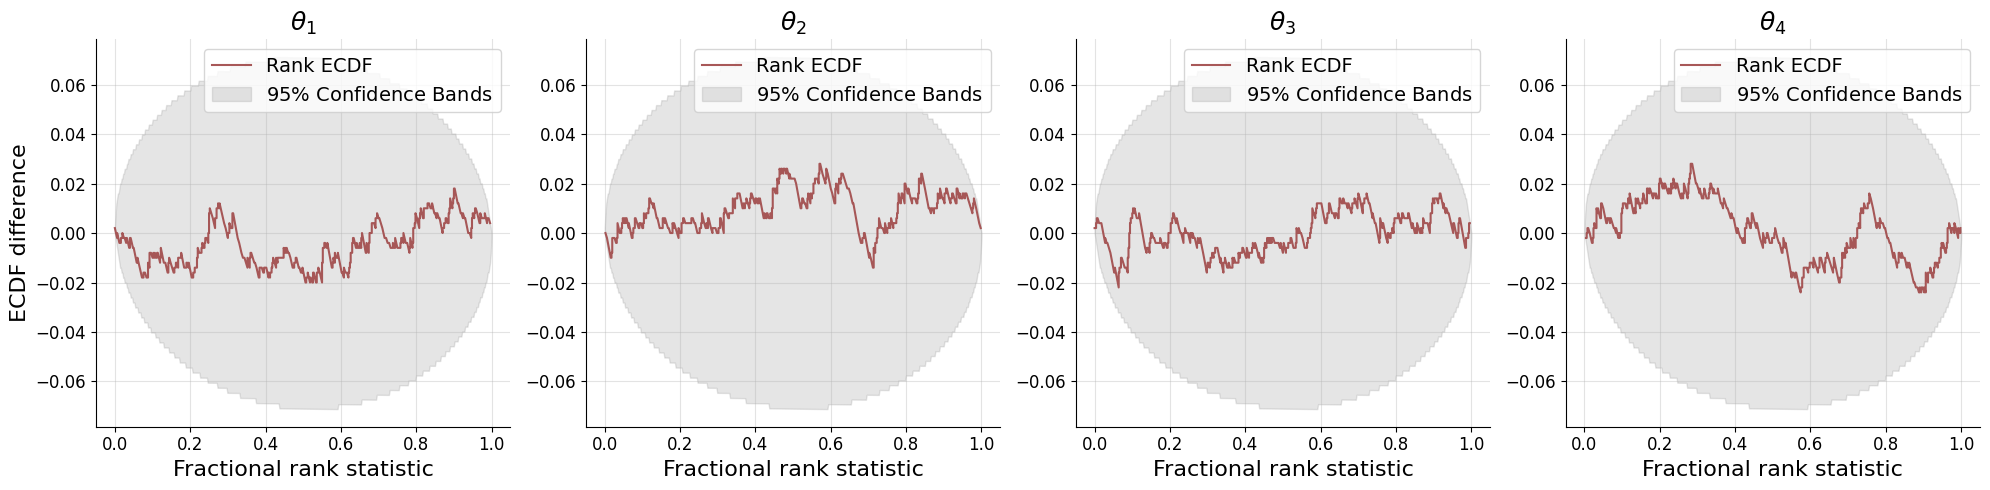

In [21]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples, difference=True)

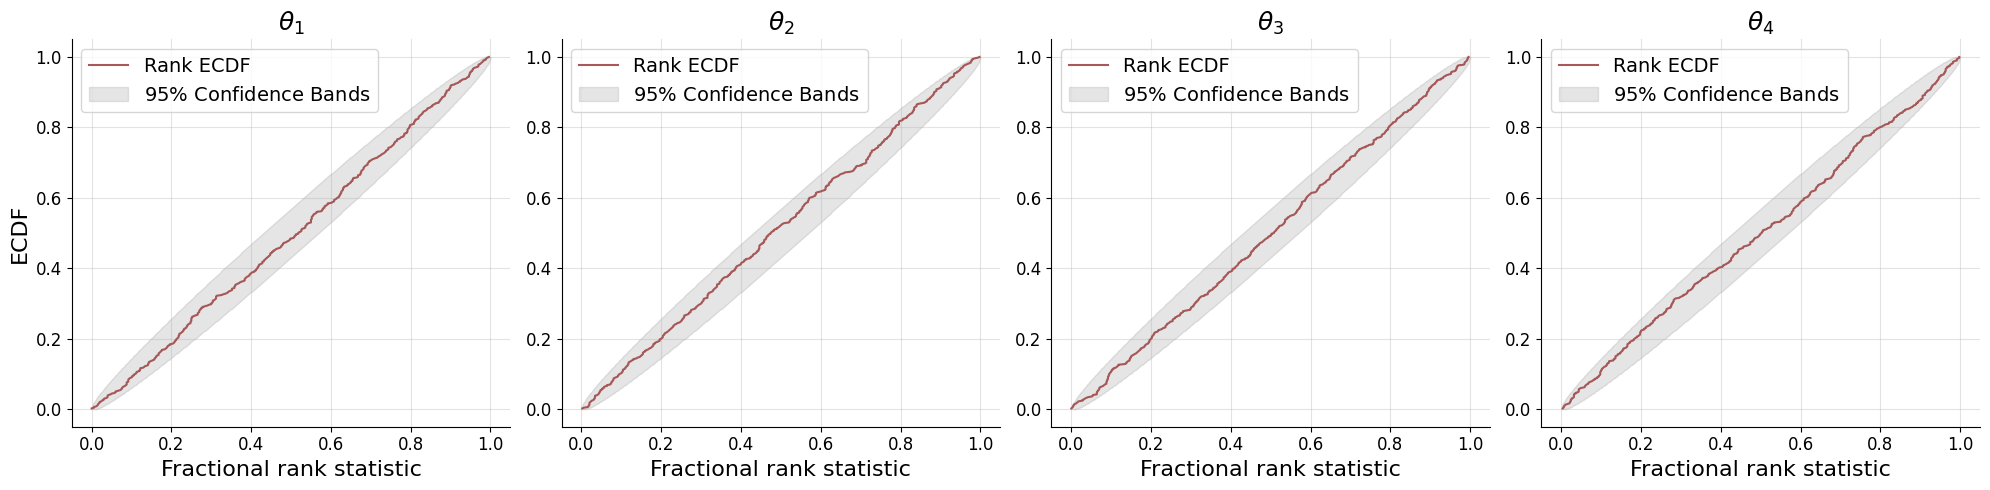

In [22]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples)

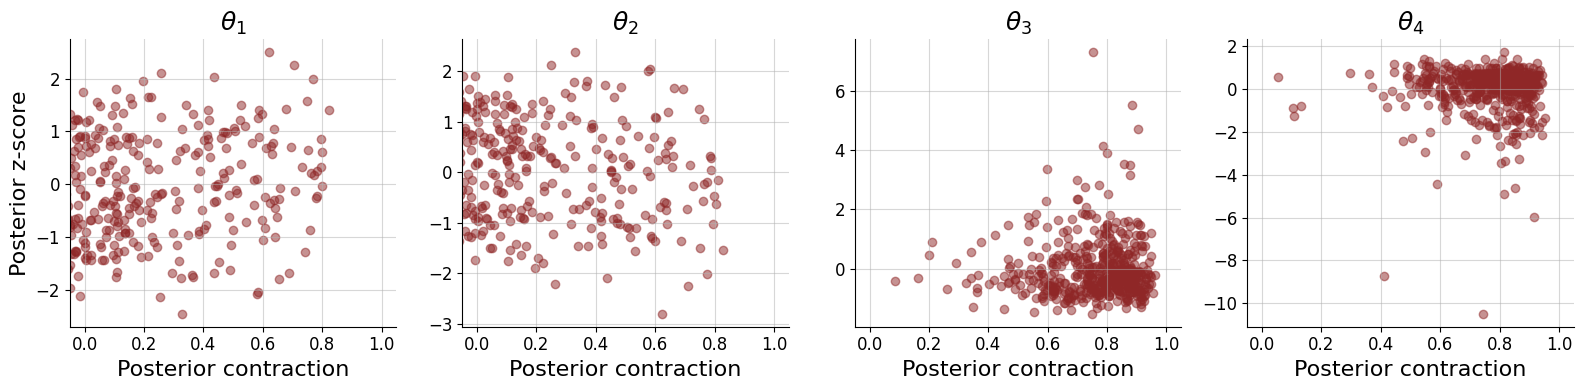

In [23]:
f = bf.diagnostics.plot_z_score_contraction(post_samples, prior_samples)

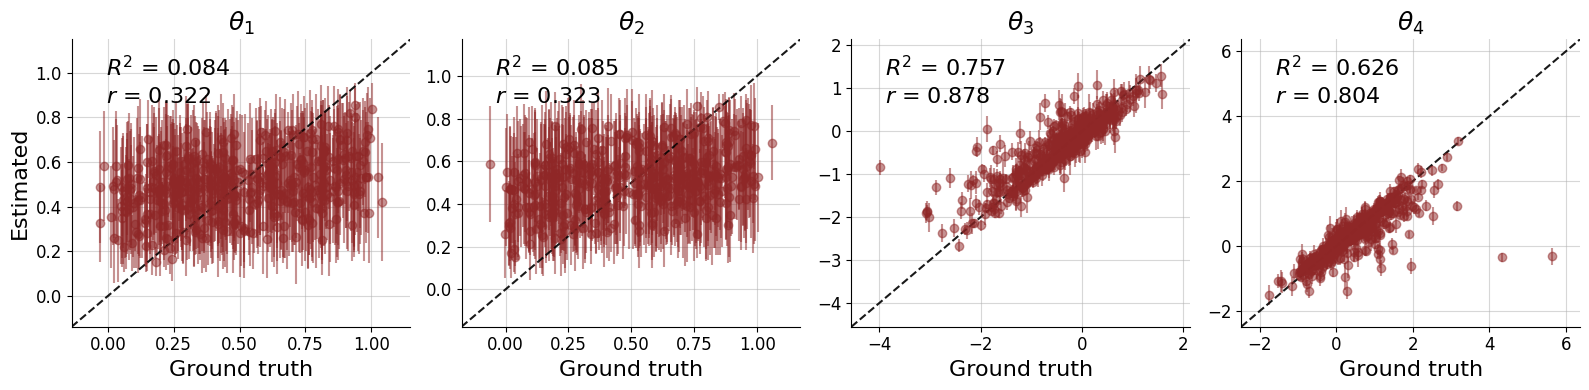

In [24]:
f = bf.diagnostics.plot_recovery(post_samples, prior_samples)